### Importar librerías

In [633]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.discriminant_analysis as da
import sklearn.neighbors as nb
from sklearn.metrics import classification_report

## Cargar Dataframe

In [634]:
df = pd.read_csv("https://raw.githubusercontent.com/opcruz/datasets/main/Weekly.csv", sep=",")
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [635]:
print('Tamaño de la muestra:', df.shape[0])

Tamaño de la muestra: 1089


### Información estadística

In [636]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1089.0,2000.048669,6.033182,1990.000000,1995.000000,2000.00000,2005.000000,2010.000000
Lag1,1089.0,0.150585,2.357013,-18.195000,-1.154000,0.24100,1.405000,12.026000
Lag2,1089.0,0.151079,2.357254,-18.195000,-1.154000,0.24100,1.409000,12.026000
Lag3,1089.0,0.147205,2.360502,-18.195000,-1.158000,0.24100,1.409000,12.026000
Lag4,1089.0,0.145818,2.360279,-18.195000,-1.158000,0.23800,1.409000,12.026000
Lag5,1089.0,0.139893,2.361285,-18.195000,-1.166000,0.23400,1.405000,12.026000
Volume,1089.0,1.574618,1.686636,0.087465,0.332022,1.00268,2.053727,9.328214
Today,1089.0,0.149899,2.356927,-18.195000,-1.154000,0.24100,1.405000,12.026000


### Matriz de correlación entre los predictores

In [637]:
df.drop(columns=['Direction']).corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Como se puede apreciar, los valores de correlación entre las variables **lag*** y **today** son cercanos a cero. Esto significa que parece haber poca correlación entre los rendimientos de hoy y los días anteriores. La única correlación importante es entre **Year** y **Volumen**.


In [638]:
df_down = df[df['Direction'] == 'Down']
df_up = df[df['Direction'] == 'Up']

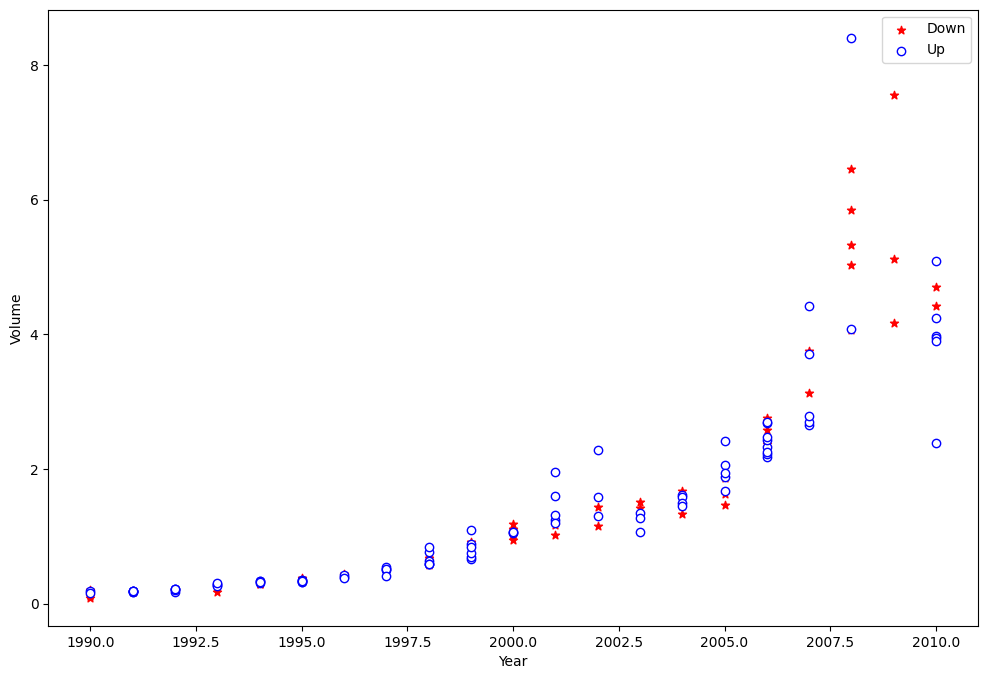

In [639]:
plt.figure(1, figsize=(12, 8))
# considerar una muestra aleatoria del 15 por ciento
df_down_15 = df_down.sample(frac=0.15)
df_up_15 = df_up.sample(frac=0.15)
plt.clf()  # clear figure
plt.xlabel('Year')
plt.ylabel('Volume')
plt.scatter(df_down_15['Year'], df_down_15['Volume'], color='red', marker='*', label="Down")
plt.scatter(df_up_15['Year'], df_up_15['Volume'], facecolors='white', edgecolors='blue', label="Up")
plt.legend()
plt.show()

Al graficar los datos, vemos que el volumen aumenta con el tiempo. En otras palabras, el número medio de acciones negociadas diariamente aumentó de 1990 a 2010.

In [640]:
df['direction_dummy'] = df['Direction'].factorize()[0]

In [641]:
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,direction_dummy
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


Down -> 0
UP   -> 1

## Regresión Logística
#### Dividir en conjunto de pruebas y entrenamiento

In [642]:
from sklearn.model_selection import train_test_split

# Entrenamiento: 80%
# Pruebas: 20%
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df['direction_dummy'])

X_train = train_set[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
X_test = test_set[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
y_train = train_set[['direction_dummy']]
y_test = test_set[['direction_dummy']]

print("Datos originales:", df.shape[0])
print("Datos para el entrenamiento:", train_set.shape[0])
print("Datos para prueba:", test_set.shape[0])

Datos originales: 1089
Datos para el entrenamiento: 871
Datos para prueba: 218


### Aplicar Regresión Logística

In [643]:
import statsmodels.api as sm

# Añadir una columna de unos para el término independiente
X_train1 = sm.add_constant(X_train)
# Ajustar el modelo
model = sm.Logit(y_train, X_train1).fit()
# Imprimir los resultados
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.681847
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        direction_dummy   No. Observations:                  871
Model:                          Logit   Df Residuals:                      864
Method:                           MLE   Df Model:                            6
Date:                Sun, 09 Apr 2023   Pseudo R-squ.:                0.007405
Time:                        15:33:10   Log-Likelihood:                -593.89
converged:                       True   LL-Null:                       -598.32
Covariance Type:            nonrobust   LLR p-value:                    0.1816
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3074      0.096      3.195      0.001       0.119       0.496
Lag1          -0.0464      0.

Si nos fijamos en los valores de probabilidad (P > |z|) podemos apreciar que el predictor estadísticamente más significativo es **lag2**, aunque cabe destacar que no posee un valor por debajo de 0.05.
El coeficiente positivo del predictor **lag2** sugiere que si el mercado tuvo un rendimiento positivo hace dos días, es más probable que suba hoy. Sin embargo, con un valor superior a 0.05 el valor p sigue siendo relativamente grande, por lo que no hay pruebas claras de una asociación real entre **Lag2** y **Direction**.

### Matriz de confusión

In [644]:
decision_prob = 0.5

X_test1 = sm.add_constant(X_test)
predictions_prob = model.predict(X_test1)
predictions = predictions_prob > decision_prob

df_ = pd.DataFrame({'True values': y_test.values.ravel(), 'Predicted values': predictions})
df_.replace(to_replace={True: 1, False: 0}, inplace=True)

df_.replace(to_replace={1: 'Up', 0: 'Down'}, inplace=True)
df_.groupby(['Predicted values', 'True values']).size().unstack('True values')


True values,Down,Up
Predicted values,,
Down,8,14
Up,89,107


Los elementos diagonales de la matriz de confusión indican predicciones correctas, mientras que los no diagonales representan predicciones incorrectas.

#### Métricas

In [645]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix

matrix_t = confusion_matrix(y_test, predictions).T

# imprimir las métricas
print('Accuracy:', round(accuracy_score(y_test, predictions), 3))
print('AUC:', round(roc_auc_score(y_test, predictions), 3))
print('Precision:', round(precision_score(y_test, predictions), 3))
print('Recall:', round(recall_score(y_test, predictions), 3))
print('Specificity:', round(matrix_t[0][0] / matrix_t.T[0].sum(), 3))

Accuracy: 0.528
AUC: 0.483
Precision: 0.546
Recall: 0.884
Specificity: 0.082


In [646]:
print(classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.364     0.082     0.134        97
           1      0.546     0.884     0.675       121

    accuracy                          0.528       218
   macro avg      0.455     0.483     0.405       218
weighted avg      0.465     0.528     0.435       218



- A primera vista, parece que el modelo de regresión logística funciona un poco mejor que la clasificación aleatoria.
- Se puede ver como el modelo posee un alto valor de sensibilidad (**Recall**), pero sacrifica en especificidad (**Specificity**).
- El modelo clasifica incorrectamente en la mayoría de las ocasiones la dirección de bajada (**Down**) como subida (**Up**).

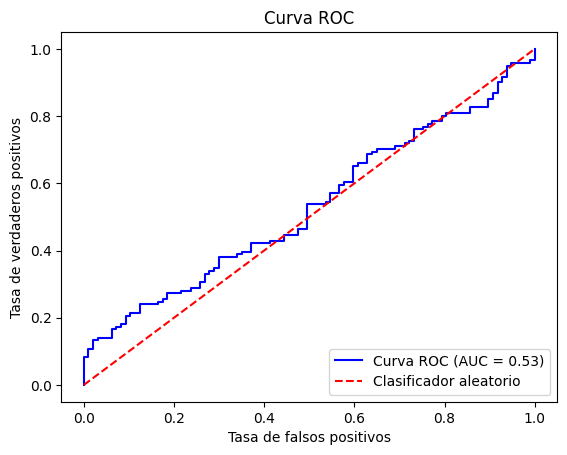

In [682]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Comparación de diferentes modelos

In [648]:
train = df[df['Year'] < 2009]
test = df[df['Year'] >= 2009]
train_X = train['Lag2']
train_y = train['direction_dummy']
test_X = test['Lag2']
test_y = test['direction_dummy']
train_X_reshaped = train_X.values.reshape(-1, 1)
test_X_reshaped = test_X.values.reshape(-1, 1)

test_y = test_y.to_numpy()

#### Regresión Logística

In [649]:
import statsmodels.api as sm

# Añadir una columna de unos para el término independiente
train_X1 = sm.add_constant(train_X)
# Ajustar el modelo
model2 = sm.Logit(train_y, train_X1).fit()
# Imprimir los resultados
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        direction_dummy   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Apr 2023   Pseudo R-squ.:                0.003076
Time:                        15:33:10   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.

In [650]:
test_X1 = sm.add_constant(test_X)
y_prob = model2.predict(test_X1)
y_prob = y_prob.to_numpy()

#### Matriz de confusión

In [651]:
decision_prob = 0.5

y_predicted = y_prob > decision_prob
df_ = pd.DataFrame({'True default status': test_y,
                    'Predicted default status': y_predicted})

# matriz de confusion
df_.replace(to_replace={True: 1, False: 0}, inplace=True)
df_.replace(to_replace={1: 'Up', 0: 'Down'}, inplace=True)
df_.groupby(['Predicted default status', 'True default status']).size().unstack('True default status')


True default status,Down,Up
Predicted default status,,
Down,9,5
Up,34,56


In [652]:
print('Accuracy:', precision_score(test_y, y_predicted))
print('AUC:', roc_auc_score(test_y, y_predicted))
print('Precision:', precision_score(test_y, y_predicted))
print('Recall:', recall_score(test_y, y_predicted))

Accuracy: 0.6222222222222222
AUC: 0.5636675562333207
Precision: 0.6222222222222222
Recall: 0.9180327868852459


In [653]:


print(classification_report(test_y, y_predicted, digits=3))

              precision    recall  f1-score   support

           0      0.643     0.209     0.316        43
           1      0.622     0.918     0.742        61

    accuracy                          0.625       104
   macro avg      0.633     0.564     0.529       104
weighted avg      0.631     0.625     0.566       104



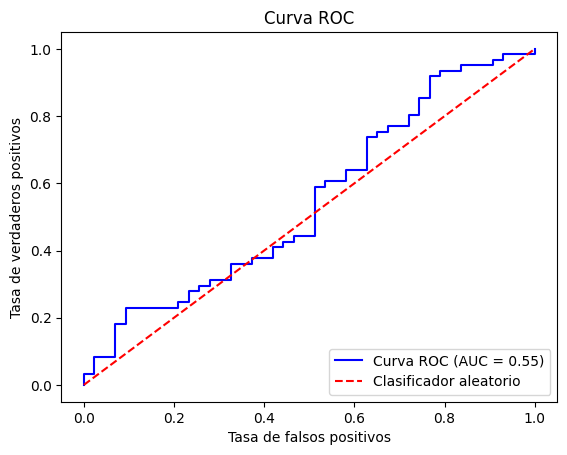

In [654]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### LDA

In [655]:
lda = da.LinearDiscriminantAnalysis()
lda.fit(train_X_reshaped, train_y.values)

LinearDiscriminantAnalysis()

In [656]:
print('Intercepto:', lda.intercept_[0])
print('Coeficiente:', lda.coef_[0][0])
print('Prioridades:', lda.priors_)

Intercepto: 0.2034239991927851
Coeficiente: 0.05768451065437437
Prioridades: [0.44771574 0.55228426]


In [657]:
predicted_lda = lda.predict(test_X_reshaped)
predicted_prob_lda = lda.predict_proba(test_X_reshaped)[:, 1]

matrix_lda = confusion_matrix(test_y, predicted_lda).T
matrix_lda

array([[ 9,  5],
       [34, 56]], dtype=int64)

In [658]:
print('Accuracy:', precision_score(test_y, predicted_lda))
print('AUC:', roc_auc_score(test_y, predicted_lda))
print('Precision:', precision_score(test_y, predicted_lda))
print('Recall:', recall_score(test_y, predicted_lda))
print('Specificity:', matrix_lda[0][0] / matrix_lda.T[0].sum())

Accuracy: 0.6222222222222222
AUC: 0.5636675562333207
Precision: 0.6222222222222222
Recall: 0.9180327868852459
Specificity: 0.20930232558139536


In [659]:
print(classification_report(test_y, predicted_lda, digits=3))

              precision    recall  f1-score   support

           0      0.643     0.209     0.316        43
           1      0.622     0.918     0.742        61

    accuracy                          0.625       104
   macro avg      0.633     0.564     0.529       104
weighted avg      0.631     0.625     0.566       104



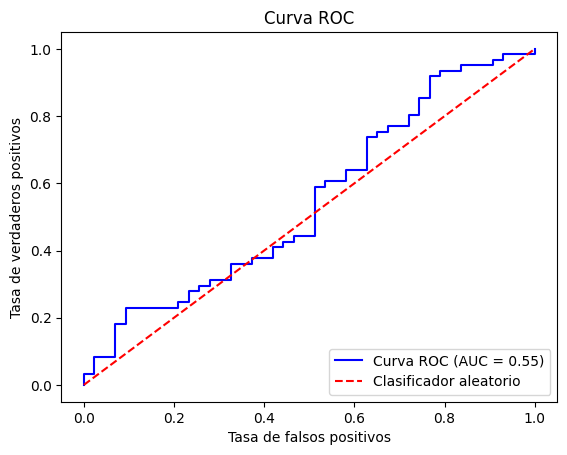

In [660]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_lda)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### QDA

In [661]:
qda = da.QuadraticDiscriminantAnalysis()
qda.fit(train_X_reshaped, train_y.values)

QuadraticDiscriminantAnalysis()

In [662]:
predicted_qda = qda.predict(test_X_reshaped)
predicted_prob_qda = qda.predict_proba(test_X_reshaped)[:, 1]

matrix_qda = confusion_matrix(test_y, predicted_qda).T
matrix_qda

array([[ 0,  0],
       [43, 61]], dtype=int64)

In [663]:
print('Accuracy:', precision_score(test_y, predicted_qda))
print('AUC:', roc_auc_score(test_y, predicted_qda))
print('Precision:', precision_score(test_y, predicted_qda))
print('Recall:', recall_score(test_y, predicted_qda))
print('Specificity:', matrix_qda[0][0] / matrix_qda.T[0].sum())

Accuracy: 0.5865384615384616
AUC: 0.5
Precision: 0.5865384615384616
Recall: 1.0
Specificity: 0.0


In [664]:
print(classification_report(test_y, predicted_qda, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        43
           1      0.587     1.000     0.739        61

    accuracy                          0.587       104
   macro avg      0.293     0.500     0.370       104
weighted avg      0.344     0.587     0.434       104



C:\Users\orest\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\orest\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\orest\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

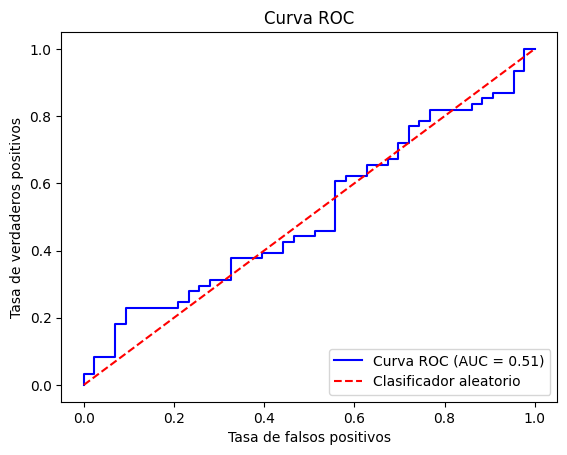

In [665]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_qda)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### KNN (k = 1)

In [666]:
knn_1 = nb.KNeighborsClassifier(n_neighbors=1)
knn_1.fit(train_X_reshaped, train_y.values)

KNeighborsClassifier(n_neighbors=1)

In [667]:
predicted_knn1 = knn_1.predict(test_X_reshaped)
predicted_prob_knn1 = knn_1.predict_proba(test_X_reshaped)[:, 1]

matrix_knn1 = confusion_matrix(test_y, predicted_knn1).T
matrix_knn1

array([[22, 30],
       [21, 31]], dtype=int64)

In [668]:
print('Accuracy:', precision_score(test_y, predicted_knn1))
print('AUC:', roc_auc_score(test_y, predicted_knn1))
print('Precision:', precision_score(test_y, predicted_knn1))
print('Recall:', recall_score(test_y, predicted_knn1))
print('Specificity:', matrix_knn1[0][0] / matrix_knn1.T[0].sum())

Accuracy: 0.5961538461538461
AUC: 0.5099123141441098
Precision: 0.5961538461538461
Recall: 0.5081967213114754
Specificity: 0.5116279069767442


In [669]:
print(classification_report(test_y, predicted_knn1, digits=3))

              precision    recall  f1-score   support

           0      0.423     0.512     0.463        43
           1      0.596     0.508     0.549        61

    accuracy                          0.510       104
   macro avg      0.510     0.510     0.506       104
weighted avg      0.525     0.510     0.513       104



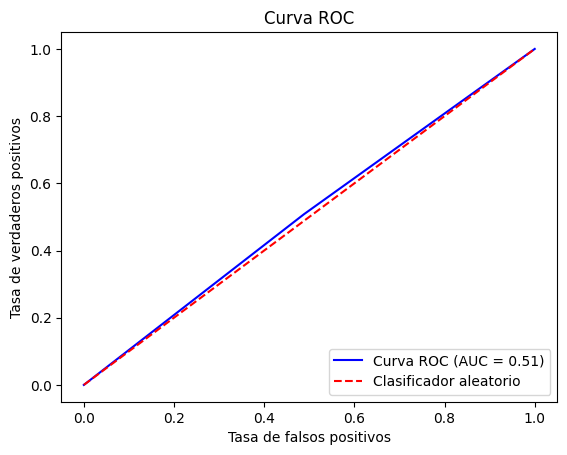

In [670]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_knn1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### KNN (k = 9)

In [671]:
knn_9 = nb.KNeighborsClassifier(n_neighbors=9)
knn_9.fit(train_X_reshaped, train_y.values)

KNeighborsClassifier(n_neighbors=9)

In [672]:
predicted_knn9 = knn_9.predict(test_X_reshaped)
predicted_prob_knn9 = knn_9.predict_proba(test_X_reshaped)[:, 1]

matrix_knn3 = confusion_matrix(test_y, predicted_knn9).T
matrix_knn3

array([[17, 21],
       [26, 40]], dtype=int64)

In [673]:
print('Accuracy:', precision_score(test_y, predicted_knn9))
print('AUC:', roc_auc_score(test_y, predicted_knn9))
print('Precision:', precision_score(test_y, predicted_knn9))
print('Recall:', recall_score(test_y, predicted_knn9))
print('Specificity:', matrix_knn3[0][0] / matrix_knn3.T[0].sum())

Accuracy: 0.6060606060606061
AUC: 0.5255432710636675
Precision: 0.6060606060606061
Recall: 0.6557377049180327
Specificity: 0.3953488372093023


In [674]:
print(classification_report(test_y, predicted_knn9, digits=3))

              precision    recall  f1-score   support

           0      0.447     0.395     0.420        43
           1      0.606     0.656     0.630        61

    accuracy                          0.548       104
   macro avg      0.527     0.526     0.525       104
weighted avg      0.540     0.548     0.543       104



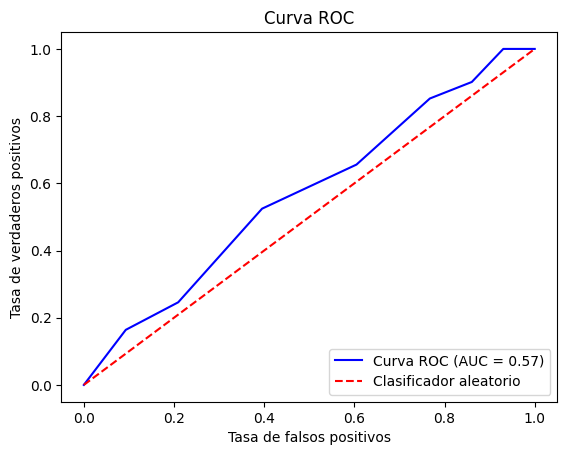

In [675]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(test_y, predicted_prob_knn9)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Experimentando con varios predictores

#### Direction ~ Lag1 + Lag2

In [676]:
train_y = train['direction_dummy']
test_y = test['direction_dummy']

train['Lag1*Lag2'] = train['Lag1'] * train['Lag2']
test['Lag1*Lag2'] = test['Lag1'] * test['Lag2']

train['Lag2*Lag3'] = train['Lag2'] * train['Lag3']
test['Lag2*Lag3'] = test['Lag2'] * test['Lag3']

train['Lag1*Lag3'] = train['Lag1'] * train['Lag3']
test['Lag1*Lag3'] = test['Lag1'] * test['Lag3']

datasets = [
    {'name': 'Direction ~ Lag1', 'train': train[['Lag1']].values.reshape(-1, 1),
     'test': test[['Lag1']].values.reshape(-1, 1)},
    {'name': 'Direction ~ Lag1 + Lag2', 'train': train[['Lag1', 'Lag2']].values,
     'test': test[['Lag1', 'Lag2']].values},
    {'name': 'Direction ~ Lag2', 'train': train[['Lag2']].values.reshape(-1, 1),
     'test': test[['Lag2']].values.reshape(-1, 1)},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag3', 'train': train[['Lag1', 'Lag2', 'Lag3']].values,
     'test': test[['Lag1', 'Lag2', 'Lag3']].values},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5',
     'train': train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']].values,
     'test': test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']].values},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag1*Lag2',
     'train': train[['Lag1', 'Lag2', 'Lag1*Lag2']].values,
     'test': test[['Lag1', 'Lag2', 'Lag1*Lag2']].values},
    {'name': 'Direction ~ Lag1 + Lag2 + Lag3 + Lag1*Lag2 + Lag2*Lag3',
     'train': train[['Lag1', 'Lag2', 'Lag3', 'Lag1*Lag2', 'Lag2*Lag3']].values,
     'test': test[['Lag1', 'Lag2', 'Lag3', 'Lag1*Lag2', 'Lag2*Lag3']].values}
]

C:\Users\orest\AppData\Local\Temp\ipykernel_8\2048755213.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Lag1*Lag2'] = train['Lag1'] * train['Lag2']
C:\Users\orest\AppData\Local\Temp\ipykernel_8\2048755213.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Lag1*Lag2'] = test['Lag1'] * test['Lag2']
C:\Users\orest\AppData\Local\Temp\ipykernel_8\2048755213.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [677]:
# Definir los modelos
from sklearn.linear_model import LogisticRegression

models = [
    {'name': 'Logistic Regression', 'model': LogisticRegression()},
    {'name': 'LDA', 'model': da.LinearDiscriminantAnalysis()},
    {'name': 'QDA', 'model': da.QuadraticDiscriminantAnalysis()},
    {'name': 'KNN k=1', 'model': nb.KNeighborsClassifier(n_neighbors=1)},
    {'name': 'KNN k=9', 'model': nb.KNeighborsClassifier(n_neighbors=9)},
    {'name': 'KNN k=15', 'model': nb.KNeighborsClassifier(n_neighbors=15)}
]

In [678]:

results = []

for dataset in datasets:
    df_metrics = pd.DataFrame()
    for model in models:
        model['model'].fit(dataset['train'], train_y.values)
        predicted_model = model['model'].predict(dataset['test'])
        matrix_model = confusion_matrix(test_y, predicted_model).T

        new_row = {
            'Accuracy': precision_score(test_y, predicted_model),
            'AUC': roc_auc_score(test_y, predicted_model),
            'Precision': precision_score(test_y, predicted_model),
            'Recall': recall_score(test_y, predicted_model),
            'Specificity': matrix_model[0][0] / matrix_model.T[0].sum()
        }
        df_metrics[model['name']] = new_row

    results.append({'name': dataset['name'], 'result': df_metrics})

for p in results:
    print(p['name'])
    print()
    print(p['result'])
    print('-------------')

Direction ~ Lag1

             Logistic Regression       LDA       QDA   KNN k=1   KNN k=9  \
Accuracy                0.585106  0.585106  0.586538  0.543860  0.577465   
AUC                     0.497331  0.497331  0.500000  0.451773  0.487228   
Precision               0.585106  0.585106  0.586538  0.543860  0.577465   
Recall                  0.901639  0.901639  1.000000  0.508197  0.672131   
Specificity             0.093023  0.093023  0.000000  0.395349  0.302326   

             KNN k=15  
Accuracy     0.565789  
AUC          0.468738  
Precision    0.565789  
Recall       0.704918  
Specificity  0.232558  
-------------
Direction ~ Lag1 + Lag2

             Logistic Regression       LDA       QDA   KNN k=1   KNN k=9  \
Accuracy                0.595506  0.595506  0.586207  0.561404  0.603175   
AUC                     0.515822  0.515822  0.499428  0.471597  0.520778   
Precision               0.595506  0.595506  0.586207  0.561404  0.603175   
Recall                  0.868852  0.86

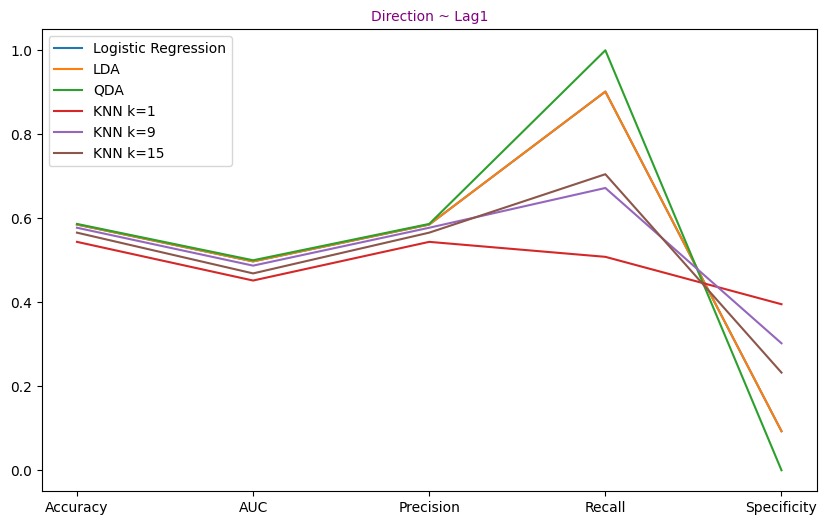

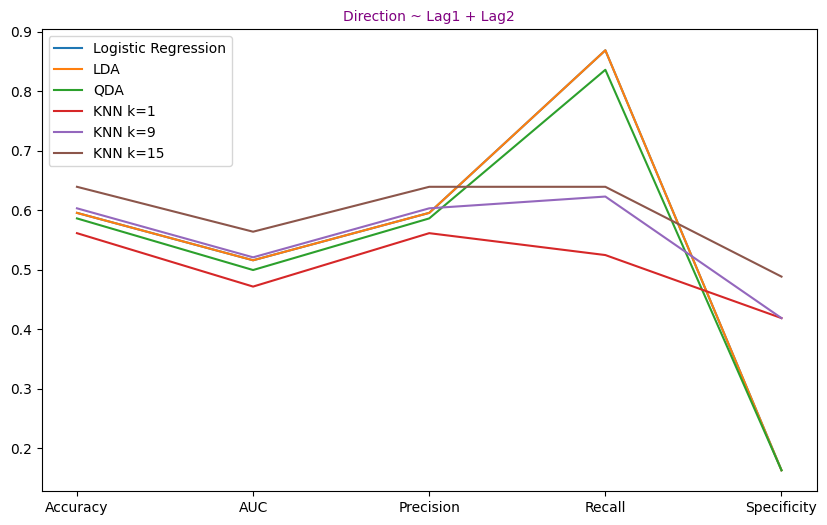

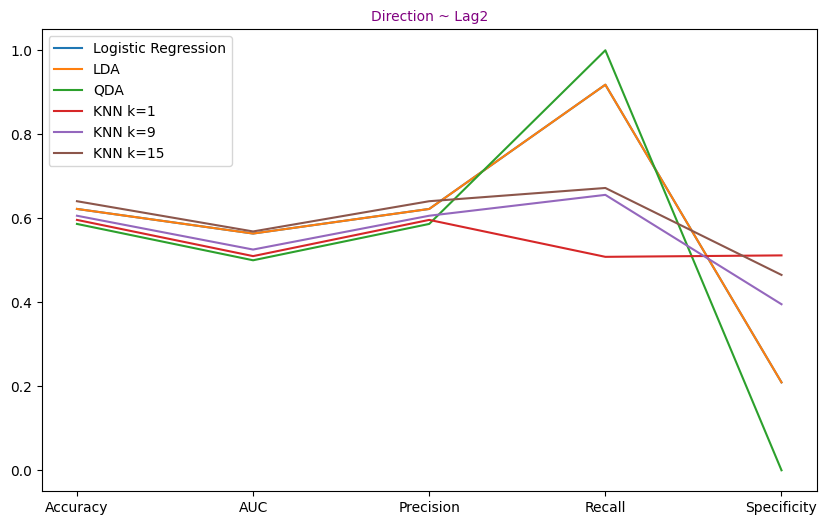

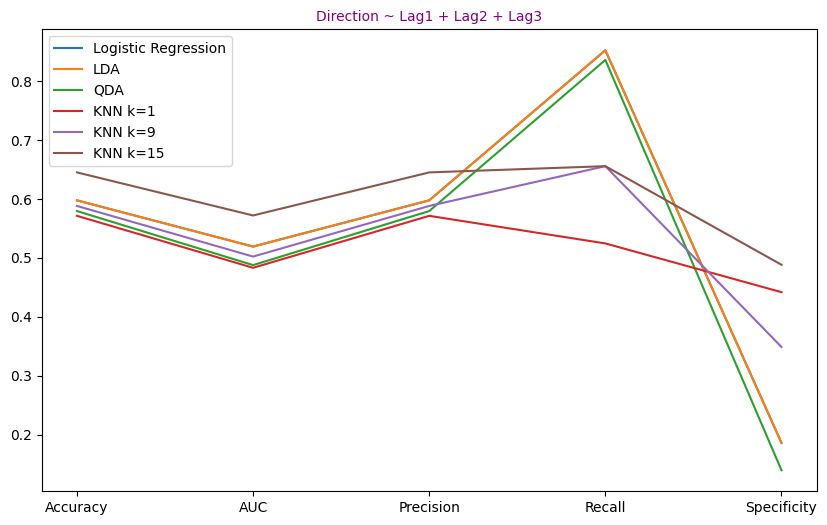

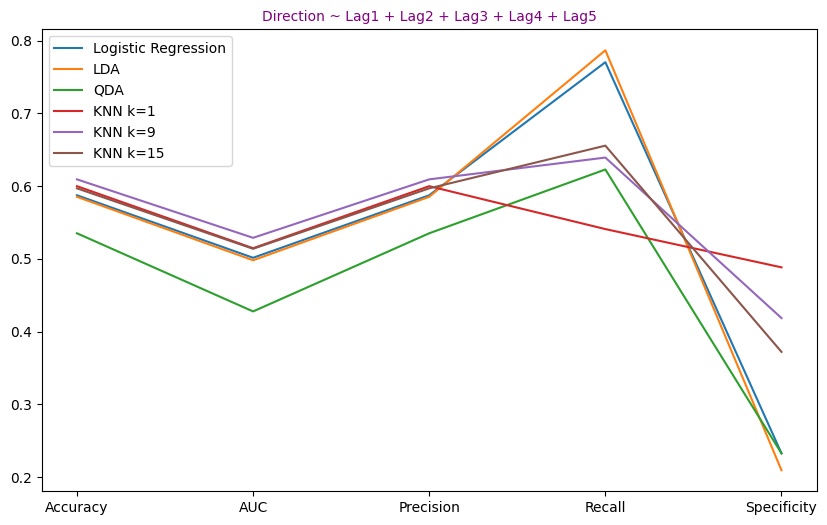

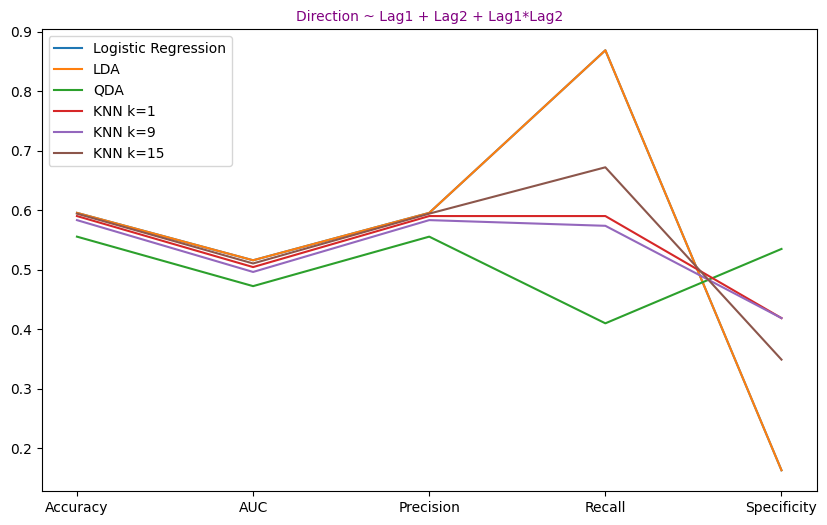

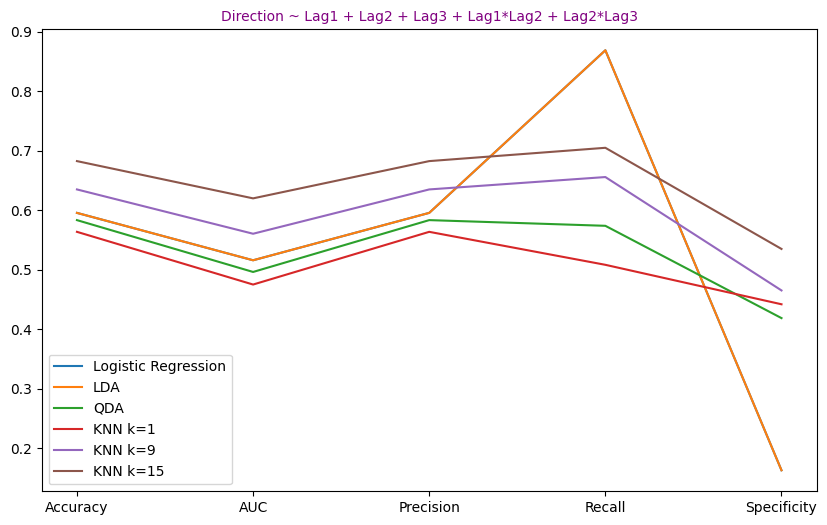

In [679]:
for result in results:
    fig = plt.figure(figsize=(10, 6))
    for column_name in result['result'].columns:
        plt.plot(result['result'][column_name], label=column_name)

    plt.legend()
    plt.title(result['name'], size=10, color="purple")
    plt.show()

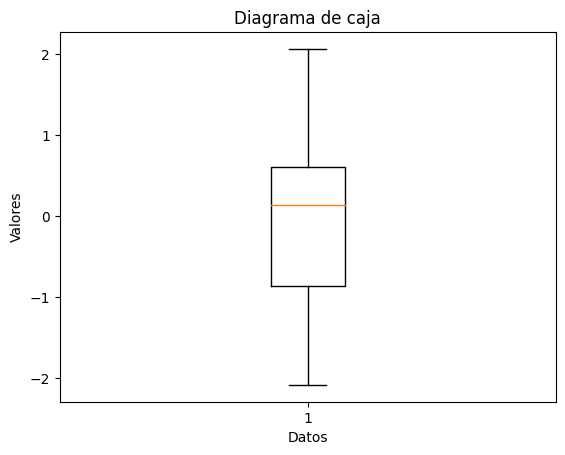

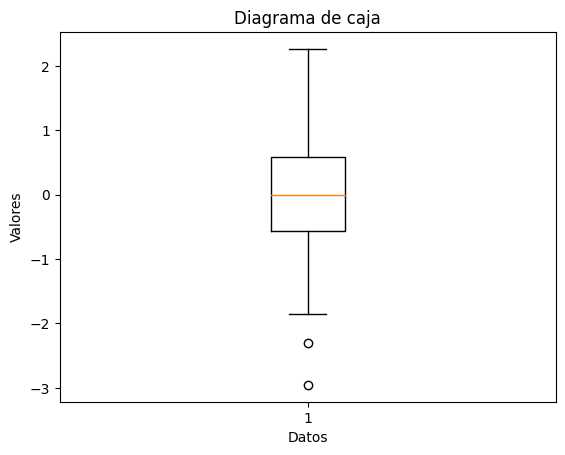

In [680]:
import matplotlib.pyplot as plt
import numpy as np
# Crea los datos que deseas visualizar en el diagrama de caja:
data = np.random.normal(size=100)
# Crea la figura y los ejes del gráfico:
fig, ax = plt.subplots()
# Crea el diagrama de caja utilizando la función boxplot() de Matplotlib:
ax.boxplot(data)
# Añade etiquetas y títulos al gráfico:
ax.set_title('Diagrama de caja')
ax.set_xlabel('Datos')
ax.set_ylabel('Valores')
# Muestra el gráfico:
plt.show()
# El código completo para crear un diagrama de caja con Matplotlib sería:

import matplotlib.pyplot as plt
import numpy as np

data = np.random.normal(size=100)

fig, ax = plt.subplots()

ax.boxplot(data)

ax.set_title('Diagrama de caja')
ax.set_xlabel('Datos')
ax.set_ylabel('Valores')

plt.show()

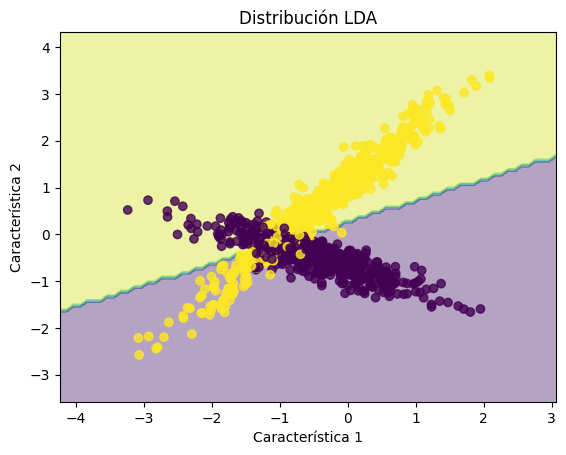

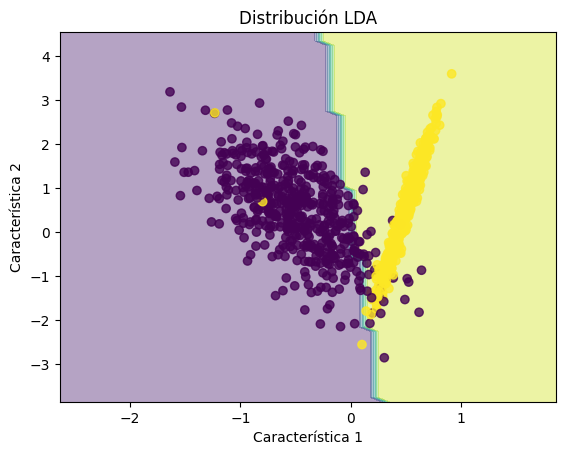

In [681]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Genera un conjunto de datos de ejemplo utilizando la función make_classification() de scikit-learn:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, class_sep=0.5)
# Entrena un modelo de LDA utilizando la función LinearDiscriminantAnalysis() de scikit-learn:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
# Genera una malla de puntos para visualizar la región de decisión del modelo:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
# Clasifica los puntos de la malla utilizando el modelo de LDA:
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Grafica la distribución de las clases y la región de decisión del modelo:
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

plt.title('Distribución LDA')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()
# El código completo para graficar la distribución de un modelo LDA sería:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, class_sep=0.5)

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

plt.title('Distribución LDA')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()